<a href="https://colab.research.google.com/github/aimerou/deep-learning/blob/main/notebooks/pytorch_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
log_interval = 10

In [3]:
torch.backends.cudnn.enabled = False
torch.manual_seed(1)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, 
  shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, 
  shuffle=True)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
class Net(nn.Module):
  def __init__(self):
        super(Net, self).__init__()
        self.bn1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
      x = F.relu(F.max_pool2d(self.conv1(self.bn1(x)), 2))
      x = F.relu(F.max_pool2d(self.conv2(self.bn2(x)), 2))
      x = x.view(-1, 320)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, training=self.training)
      x = self.fc2(x)
      return F.log_softmax(x)

In [7]:
network = Net()
optimizer = optim.Adam(network.parameters())

In [8]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [9]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [10]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [11]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3316, Accuracy: 1137/10000 (11%)


Test set: Avg. loss: 0.0692, Accuracy: 9791/10000 (98%)


Test set: Avg. loss: 0.0475, Accuracy: 9841/10000 (98%)


Test set: Avg. loss: 0.0403, Accuracy: 9887/10000 (99%)


Test set: Avg. loss: 0.0337, Accuracy: 9887/10000 (99%)


Test set: Avg. loss: 0.0292, Accuracy: 9903/10000 (99%)



Text(0, 0.5, 'cross entropy loss')

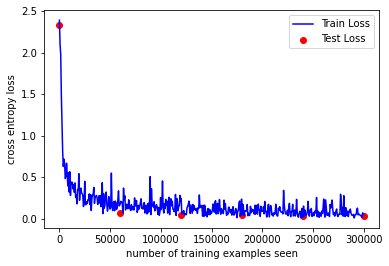

In [12]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross entropy loss')

In [13]:
example_data = []
for data, target in test_loader:
  example_data.append(data[0:1])
example_data = torch.cat(example_data)
example_data.shape

torch.Size([10, 1, 28, 28])

In [14]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


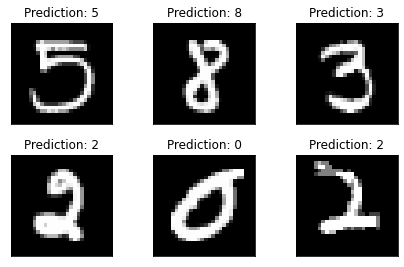

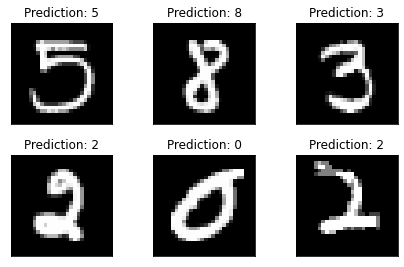

In [15]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig